<div style="text-align: justify;">

## Programming Exercises Q1: Dataset Selection (Spatial Data)

### What is Geospatial Data?
Geospatial data is any data that contains information about a specific **location on the Earth’s surface**. It usually includes geographic coordinates (latitude/longitude) and may also include descriptive attributes (name, type, category, address, etc.).

### Selected Dataset
For this assignment, I selected a geospatial dataset from **OpenStreetMap (OSM)**, a global and publicly available geographic database maintained by contributors, and extracted the data using the **Overpass API**, which allows location-based queries such as searching within a specified radius around a point. Specifically, my dataset contains the locations and attributes of car showrooms and dealerships in the radius of 30KM around KFUPM, collected using OSM tags like **shop=car and amenity=car_dealer**. 

This dataset is useful because it supports practical spatial analysis tasks such as identifying where dealerships are concentrated (hotspots), understanding commercial clustering patterns along major roads, and assisting in business location analysis and urban/commercial planning decisions.

### Study Area (Location and Radius)
- **Center location:** King Fahd University of Petroleum & Minerals (KFUPM), Saudi Arabia  
- **Coordinates used:** `(26.307, 50.1459)` (latitude, longitude)  
- **Search radius:** `30,000 meters (30 km)`

This radius captures KFUPM and nearby surrounding cities/areas where car dealerships commonly exist.

### Data Collection Method
The dataset is collected by sending an **Overpass query** to extract objects tagged as:
- `shop=car`  (car shops/showrooms)
- `amenity=car_dealer` (car dealerships)

The query includes three OSM object types:
- **node** (single point location)
- **way** (polygon/line feature; converted to center point using `out center`)
- **relation** (complex features; converted to center point using `out center`)

The query returns results in a GeoJSON-like structure (FeatureCollection), which is convenient for mapping and visualization.

### Attributes Collected
For each showroom/dealership, the following information is extracted (when available):
- `name` (e.g., showroom name)
- `brand` or `operator` (e.g., Toyota, Hyundai, etc.)
- `addr:*` or `address` (street/address fields)
- `phone` / `contact:phone`
- `website` / `contact:website`
- `latitude` and `longitude` (coordinates)
- `osm_id` (unique identifier)

These attributes provide both **spatial** (where it is) and **non-spatial** (what it is) information.

### Summary
The selected dataset is a **public geospatial dataset** from OpenStreetMap, collected via Overpass API for a defined study region around KFUPM. Each record includes geographic coordinates and descriptive attributes, making it suitable for multiple spatial visualizations and analysis (choropleth, cartogram, bubble, hexbin, heatmap, and clustering).


In [1]:
# !pip install overpass (trunging it off afterinstallation)
import time
import overpass

# Because of the larger range (30KM) Try multiple endpoints and retry on server load/errors
ENDPOINTS = [
    "https://overpass-api.de/api/interpreter",
    "https://lz4.overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
]

# Define the location for the query (KFUPM)
LOCATION = (26.307, 50.1459)  # (lat, lon)
DISTANCE_M = 30000  # radius in meters

# Overpass query
overpass_query = f"""
(
  node["shop"="car"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  way["shop"="car"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  relation["shop"="car"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});

  node["amenity"="car_dealer"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  way["amenity"="car_dealer"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
  relation["amenity"="car_dealer"](around:{DISTANCE_M},{LOCATION[0]},{LOCATION[1]});
);
out center;
"""

def fetch_with_retries(query: str, endpoints: list[str], max_retries: int = 5, base_wait: int = 5):
    """
    Try each endpoint in order. For each endpoint, retry with linear backoff.
    Returns GeoJSON dict on success.
    Raises the last exception if all attempts fail.
    """
    last_exc: Exception | None = None

    for endpoint in endpoints:
        api = overpass.API(endpoint=endpoint, timeout=600)

        for attempt in range(1, max_retries + 1):
            try:
                return api.get(query)
            except Exception as e:
                last_exc = e
                time.sleep(base_wait * attempt)

    if last_exc is not None:
        raise last_exc
    raise RuntimeError("No endpoints provided.")

try:
    cars_showrooms = fetch_with_retries(overpass_query, ENDPOINTS)
except Exception as e:
    # fallback to empty FeatureCollection if all endpoints/retries fail
    cars_showrooms = {"type": "FeatureCollection", "features": []}
    print(f"Overpass query failed after retries: {e}")

# Optional: quick summary
print(f"Features returned: {len(cars_showrooms.get('features', []))}")



Features returned: 106


In [2]:
cars_showrooms

{"features": [{"geometry": {"coordinates": [50.174333, 26.373624], "type": "Point"}, "id": 4116103589, "properties": {"addr:street": "King Fahd bin Abdelaziz Street", "name": "وكالة الجزيرة", "name:en": "Jazirah Auto Dealer", "opening_hours": "Sa-Th 08:00-12:00, 16:00-20:00", "shop": "car"}, "type": "Feature"}, {"geometry": {"coordinates": [50.04789, 26.399183], "type": "Point"}, "id": 4119330297, "properties": {"addr:street": "King Fahad Ibn Abdul Aziz Road", "name": "Llumar window film", "shop": "car"}, "type": "Feature"}, {"geometry": {"coordinates": [50.196202, 26.336125], "type": "Point"}, "id": 4230218891, "properties": {"addr:street": "Prince Sultan Bin Abdul Aziz Street", "brand": "Lamborghini", "brand:wikidata": "Q35886", "name": "Lamborghini/Bentley showrooms", "shop": "car"}, "type": "Feature"}, {"geometry": {"coordinates": [50.185846, 26.286797], "type": "Point"}, "id": 4450335794, "properties": {"name:en": "Gma Showroom", "shop": "car"}, "type": "Feature"}, {"geometry": {"

<div style="text-align: justify;">

## Data Extraction and Printing (Car Showrooms & Dealerships)

### Step 1 — Set the study area
I defined the center point of the study as **KFUPM** using its latitude and longitude, and selected a **30 km radius** around it. This helps limit the results to only the nearby region that I want to analyze.

### Step 2 — Load the Overpass API results
After running the Overpass query, the results are stored in the variable `cars_showrooms`.  
This data is returned in a GeoJSON-like format where each place is stored as a **feature** inside:
- `cars_showrooms["features"]`

### Step 3 — Check the data (debugging)
Before printing the list, I printed:
- the type of `cars_showrooms`,
- the available keys (to confirm the structure),
- and the number of features returned.

This step ensures the data is correctly collected and available for processing.

### Step 4 — Loop through all locations
I used a loop to go through each feature one by one and assigned a **serial number** (`sr_no`) using `enumerate()`.  
This allows printing results in a numbered list format (1, 2, 3, ...).

### Step 5 — Extract key information from each feature
For every showroom/dealership, I extracted important details such as:
- `name` (showroom name)
- `brand` (car brand or operator)
- `address` (if available)
- `phone` and `website` (if available)

Since OpenStreetMap data may not have all fields, I used **fallback values** like:
- `"Unnamed"` if name is missing,
- `"Unknown Brand"` if brand is missing,
- `"N/A"` if phone/website is missing.

### Step 6 — Extract coordinates (latitude and longitude)
Each feature contains its geographic location in the `geometry` section.  
If the feature is a point, I extracted coordinates from:
- `geometry["coordinates"]`  
(GeoJSON stores it as **[longitude, latitude]**, so I assigned them correctly.)

### Step 7 — Save the cleaned results
I stored each processed showroom/dealership into a list called `showrooms_locations`.  
This list creates a clean dataset that can later be used for visualization (heatmaps, choropleths, clustering, etc.).

### Step 8 — Print the results in list form
Finally, I printed each showroom in a clear format with:
- serial number
- name
- brand
- latitude/longitude
- and other optional details (address, phone, website)

### Step 9 — Show summary statistics (brand distribution)
At the end, I counted how many showrooms belong to each brand using `Counter`.  
This provides a quick idea of which car brands appear most frequently in the selected area.


In [3]:

from collections import Counter

# Make sure these names match what you used earlier:
location = LOCATION        # or comment this if you already have location
distance = DISTANCE_M      # or comment this if you already have distance

print("\n" + "=" * 70)
print("LIST OF CAR SHOWROOMS & DEALERSHIPS")
print(f"Location: KFUPM ({location[0]}, {location[1]}) | Radius: {distance/1000:.1f}km")
print("=" * 70)

# --- DEBUG (helps confirm you are reading the right data) ---
print("Debug: cars_showrooms type =", type(cars_showrooms))
print("Debug: keys =", list(cars_showrooms.keys()) if isinstance(cars_showrooms, dict) else "N/A")

features = cars_showrooms.get("features", []) if isinstance(cars_showrooms, dict) else []
print("Debug: number of features =", len(features))

showrooms_locations = []

if not features:
    print("\n⚠ No car showrooms found in this area (features list is empty).")
else:
    for sr_no, feature in enumerate(features, start=1):
        properties = feature.get("properties", {}) or {}
        geometry = feature.get("geometry", {}) or {}

        # Get name and brand
        name = properties.get("name") or "Unnamed"
        brand = properties.get("brand") or properties.get("operator") or "Unknown Brand"

        # Extra details
        address = (
            properties.get("addr:full")
            or properties.get("addr:street")
            or properties.get("address")
            or "Address not available"
        )
        phone = properties.get("phone") or properties.get("contact:phone") or "N/A"
        website = properties.get("website") or properties.get("contact:website") or "N/A"

        # Coordinates (GeoJSON Point)
        lat = lon = None
        if geometry.get("type") == "Point":
            coords = geometry.get("coordinates", [])
            if len(coords) >= 2:
                lon, lat = coords[0], coords[1]

        # If coords missing, still print entry (don’t silently skip)
        lat_str = f"{lat:.6f}" if isinstance(lat, (float, int)) else "N/A"
        lon_str = f"{lon:.6f}" if isinstance(lon, (float, int)) else "N/A"

        showrooms_locations.append({
            "sr_no": sr_no,
            "name": name,
            "brand": brand,
            "latitude": lat,
            "longitude": lon,
            "address": address,
            "phone": phone,
            "website": website,
            "osm_id": properties.get("@id") or properties.get("id") or feature.get("id") or "N/A",
        })

        # Print result (ALL)
        print(f"\n{sr_no}. {name}", flush=True)
        print(f"   🏢 Brand:    {brand}", flush=True)
        print(f"   📍 Location: {lat_str}, {lon_str}", flush=True)
        if address != "Address not available":
            print(f"   🏠 Address:  {address}", flush=True)
        if phone != "N/A":
            print(f"   📞 Phone:    {phone}", flush=True)
        if website != "N/A":
            print(f"   🌐 Website:  {website}", flush=True)

print("\n" + "=" * 70)
print(f"TOTAL SHOWROOMS FOUND: {len(showrooms_locations)}")
print("=" * 70)

# Summary by brand
brands = [s["brand"] for s in showrooms_locations if s["brand"] and s["brand"] != "Unknown Brand"]
if brands:
    print("\nBrand Distribution:")
    for brand, count in Counter(brands).most_common():
        print(f"  • {brand}: {count}")





LIST OF CAR SHOWROOMS & DEALERSHIPS
Location: KFUPM (26.307, 50.1459) | Radius: 30.0km
Debug: cars_showrooms type = <class 'geojson.feature.FeatureCollection'>
Debug: keys = ['type', 'features']
Debug: number of features = 106

1. وكالة الجزيرة
   🏢 Brand:    Unknown Brand
   📍 Location: 26.373624, 50.174333


   🏠 Address:  King Fahd bin Abdelaziz Street

2. Llumar window film
   🏢 Brand:    Unknown Brand
   📍 Location: 26.399183, 50.047890
   🏠 Address:  King Fahad Ibn Abdul Aziz Road

3. Lamborghini/Bentley showrooms
   🏢 Brand:    Lamborghini
   📍 Location: 26.336125, 50.196202
   🏠 Address:  Prince Sultan Bin Abdul Aziz Street

4. Unnamed
   🏢 Brand:    Unknown Brand
   📍 Location: 26.286797, 50.185846

5. Unnamed
   🏢 Brand:    Unknown Brand
   📍 Location: 26.284098, 50.184535

6. Unnamed
   🏢 Brand:    Unknown Brand
   📍 Location: 26.285588, 50.189937

7. Unnamed
   🏢 Brand:    Unknown Brand
   📍 Location: 26.285999, 50.188856

8. صالة ماهر الهلال للسيارات
   🏢 Brand:    Unknown Brand
   📍 Location: 26.456213, 50.127927
   🏠 Address:  Al Ashreah
   📞 Phone:    +966555851413
   🌐 Website:  http://maher1413@yahoo.com

9. Unnamed
   🏢 Brand:    Unknown Brand
   📍 Location: 26.399642, 50.015180

10. Geeley
   🏢 Brand:    Unknown Brand
   📍 Location: 26.373380, 50.174617

11. Mercedes-Benz

<div style="text-align: justify;">

## Converting the Collected Locations into a DataFrame

In this step, I converted the extracted showroom/dealership records stored in `showrooms_locations` into a **Pandas DataFrame** for easier analysis and visualization. First, I installed and imported the `pandas` library. Then, I created a DataFrame using `pd.DataFrame(showrooms_locations)`, where each dictionary becomes a row and each key becomes a column (e.g., name, brand, latitude, longitude, etc.). After that, I removed any rows with missing geographic coordinates using `dropna(subset=["latitude", "longitude"])` because valid latitude and longitude values are required for all spatial visualizations (maps, heatmaps, hexbin, clustering). Finally, I displayed a preview using `df.head()` and checked the total number of valid records using `len(df)`.


In [4]:
#!pip -q install pandas

import pandas as pd

df = pd.DataFrame(showrooms_locations).copy()

# keep only valid points
df = df.dropna(subset=["latitude", "longitude"])
df.head(), len(df)


(   sr_no                           name          brand   latitude  longitude  \
 0      1                  وكالة الجزيرة  Unknown Brand  26.373624  50.174333   
 1      2             Llumar window film  Unknown Brand  26.399183  50.047890   
 2      3  Lamborghini/Bentley showrooms    Lamborghini  26.336125  50.196202   
 3      4                        Unnamed  Unknown Brand  26.286797  50.185846   
 4      5                        Unnamed  Unknown Brand  26.284098  50.184535   
 
                                address phone website      osm_id  
 0       King Fahd bin Abdelaziz Street   N/A     N/A  4116103589  
 1       King Fahad Ibn Abdul Aziz Road   N/A     N/A  4119330297  
 2  Prince Sultan Bin Abdul Aziz Street   N/A     N/A  4230218891  
 3                Address not available   N/A     N/A  4450335794  
 4                Address not available   N/A     N/A  4450394990  ,
 98)

<div style="text-align: justify;">

## Question 2 : Spatial Data Visualization and Insights

### Purpose
The main purpose of this part is to **visualize the collected geospatial dataset** (car showrooms and dealerships around KFUPM) in multiple spatial formats. Visualization helps transform raw latitude/longitude points into meaningful patterns, making it easier to understand **where the showrooms are concentrated**, how they are distributed across the city, and whether they form **clusters or hotspots** along important roads or commercial areas. In this task, I used six common spatial visualization techniques: **choropleth map, cartogram map, bubble map, hexagonal binning, heat map, and cluster map**.

### How I did it (overall process)
1. **Prepared the dataset**  
   After collecting the Overpass API results, I stored the cleaned showroom records in `showrooms_locations`.  
   Then I converted them into a Pandas DataFrame (`df`) and removed any rows with missing latitude/longitude so that every record has valid coordinates, as explained in above step

2. **Created geospatial objects for mapping**  
   For visualizations that required mapping and basemaps, I converted the DataFrame into a **GeoDataFrame** (using GeoPandas) and projected the data into **EPSG:3857** so that it aligns correctly with OpenStreetMap basemaps.

3. **Visualized the data using different methods (one by one)**  
   For each method, I used the simplest possible library setup:
   - Matplotlib / GeoPandas for static plots (choropleth, cartogram, hexbin)
   - Contextily for adding basemap tiles
   - Folium plugins for interactive maps (heat map and cluster map)

4. **Reported observations and insights**  
   After each visualization, I added a markdown cell to explain what the map shows and what patterns can be observed.

## Visualizations and Observations

### 1) Choropleth-style Map (Grid-based)
**What it shows:**  
The choropleth-style grid map divides the study area into equal-sized grid cells (e.g., 3 km × 3 km) and colors each cell based on how many showrooms fall inside it.

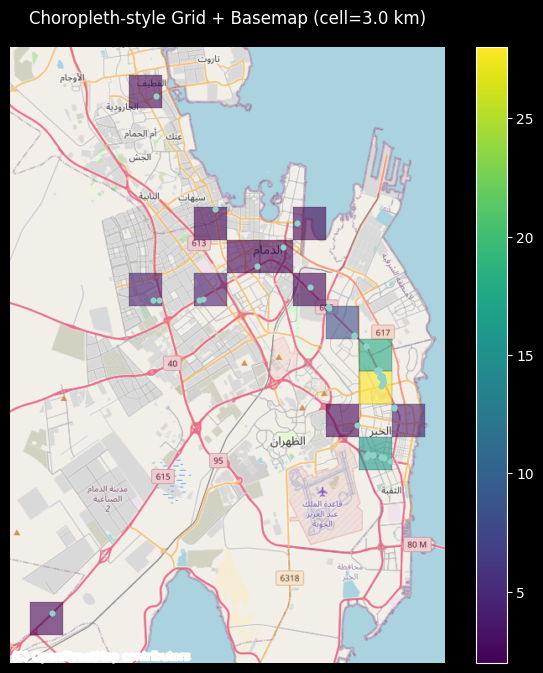

In [5]:
#!pip -q install geopandas shapely pyproj matplotlib contextily

import geopandas as gpd
from shapely.geometry import Point, box
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

# GeoDataFrame (lat/lon)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# Project to Web Mercator for basemap
gdf_m = gdf.to_crs(epsg=3857)

# Grid size
cell_size = 3000  # meters (3 km)
xmin, ymin, xmax, ymax = gdf_m.total_bounds

# Padding around data
pad = 5000
xmin, ymin, xmax, ymax = xmin - pad, ymin - pad, xmax + pad, ymax + pad

# Create grid
cols = np.arange(xmin, xmax + cell_size, cell_size)
rows = np.arange(ymin, ymax + cell_size, cell_size)

polys = [box(x0, y0, x0 + cell_size, y0 + cell_size) for x0 in cols[:-1] for y0 in rows[:-1]]
grid = gpd.GeoDataFrame({"geometry": polys}, crs=gdf_m.crs)

# Count points per cell
joined = gpd.sjoin(gdf_m, grid, predicate="within", how="left")
counts = joined.groupby("index_right").size()

grid["count"] = 0
grid.loc[counts.index, "count"] = counts.values

# Keep only non-empty cells
grid_nz = grid[grid["count"] > 0].copy()

# ---- Plot ONE map (with basemap) ----
fig, ax = plt.subplots(figsize=(8, 8))

grid_nz.plot(
    ax=ax,
    column="count",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    alpha=0.6
)

gdf_m.plot(ax=ax, markersize=10)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Choropleth-style Grid + Basemap (cell={cell_size/1000:.1f} km)")
ax.set_axis_off()
plt.show()




<div style="text-align: justify;">

### Insights & Observations 

- The colored grid cells represent how many car showrooms/dealerships fall inside each **3 km × 3 km** area. Darker/brighter cells indicate **higher concentration**.
- The map shows a **clear hotspot** in the eastern/coastal side (the brightest cell), meaning many showrooms are located very close to each other in that commercial zone.
- Several medium-density cells appear around central parts of the city, which suggests there are **secondary dealership zones** besides the main hotspot.
- Most cells with showrooms are in **Al Rakah Al Janubiyah and in Al Khobar** located near **major roads and intersections**, which indicates dealerships prefer locations with high accessibility and visibility for customers.
- A few isolated low-density cells (single or small counts) appear farther from the main clusters, suggesting some dealerships are **scattered** outside the primary commercial district.
- Overall, the distribution is **not uniform**: showrooms are concentrated in specific corridors/areas rather than being evenly spread across the region.



<div style="text-align: justify;">

### 2) Cartogram Map (Scaled Symbols per Grid Cell)
**What it shows:**  
Instead of coloring grid cells, the cartogram-like map places circles at grid centroids and scales their size according to the number of showrooms in that grid cell.

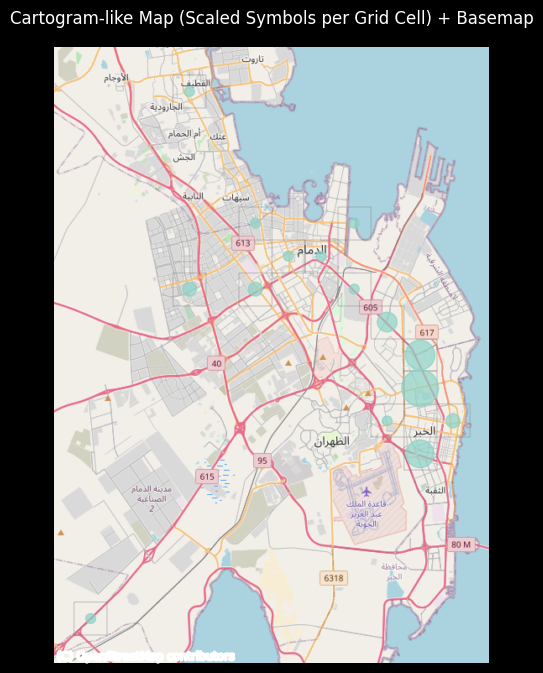

In [6]:

import contextily as ctx
import matplotlib.pyplot as plt

# Create centroids from grid_nz
centroids = grid_nz.copy()
centroids["geometry"] = centroids.geometry.centroid

fig, ax = plt.subplots(figsize=(8, 8))

# draw grid lightly for reference
grid_nz.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.3)

# plot scaled centroid markers
centroids.plot(ax=ax, markersize=centroids["count"] * 25, alpha=0.7)

# basemap (requires EPSG:3857, which we already have)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Cartogram-like Map (Scaled Symbols per Grid Cell) + Basemap")
ax.set_axis_off()
plt.show()


<div style="text-align: justify;">

**Insights observed:**
- The largest circles represent **dominant showroom zones**.
- If one circle is much larger than others, it suggests the market is **centralized** in one major district.
- Multiple medium circles indicate **multiple commercial hubs** rather than one single center.
- With basemap, it becomes easier to link high-density areas to main roads and central districts.

---


### 3) Bubble Map

**What it shows:**  
Each showroom is represented as a circle marker (bubble). Bubble size can be scaled using a variable (e.g., brand frequency), which helps compare dominance.

In [7]:
!jupyter trust "geospatial_assigment.ipynb"
#!pip -q install folium

import folium
import math

center = [df["latitude"].mean(), df["longitude"].mean()]
m_bubble = folium.Map(location=center, zoom_start=11)

brand_counts = df["brand"].value_counts()

for _, row in df.iterrows():
    brand = row["brand"]
    count = int(brand_counts.get(brand, 1))
    radius = 3 + 2 * math.sqrt(count)   # simple scaling

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=radius,
        fill=True,
        fill_opacity=0.5,
        popup=f"{row['name']}<br>Brand: {brand}<br>Brand count: {count}"
    ).add_to(m_bubble)

m_bubble




Signing notebook: geospatial_assigment.ipynb


<div style="text-align: justify;">

### Insights observed

- Each bubble represents a **car showroom/dealership location**, and the bubble size reflects the chosen scaling factor (e.g., how frequently a brand appears or the weight assigned in the visualization).
- The largest bubbles appear mainly along the **Al Rakah Al Janubiyah and in Al Khobar**, showing that this area has the strongest presence and activity related to car showrooms/dealers.
- Several medium bubbles are visible around central areas, indicating **secondary commercial zones** where dealerships also exist but with lower concentration than the main hotspot.
- The distribution is clearly **clustered rather than uniform**: bubbles are concentrated along major roads and key intersections, suggesting dealerships prefer locations with high accessibility and customer traffic.
- A few smaller and isolated bubbles appear farther away from the main corridor, which suggests some dealerships operate as **standalone locations** outside the primary market area.


<div style="text-align: justify;">

### 4) Hexagonal Binning
**What it shows:**  
Hexagonal binning groups points into hexagon cells and colors them by density. It is useful when points overlap and are hard to see individually.


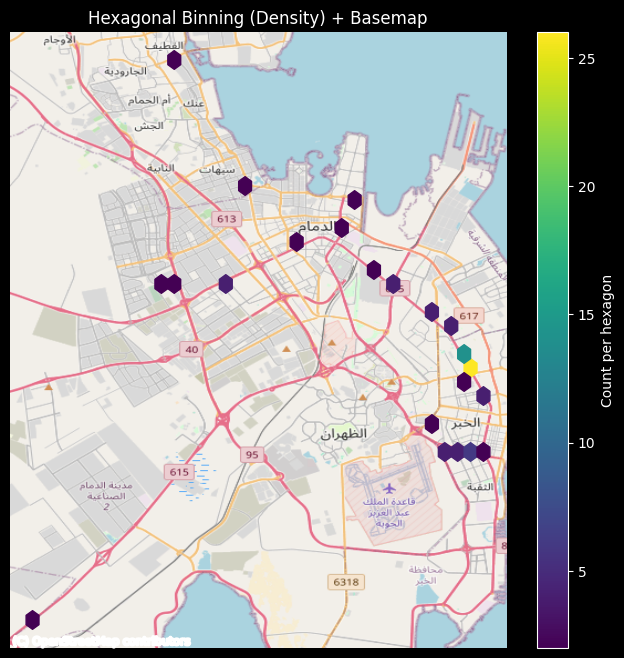

In [8]:

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# Make a GeoDataFrame from df (lat/lon)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# Project to EPSG:3857 for basemap
gdf_m = gdf.to_crs(epsg=3857)

# Hexbin + basemap
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(
    gdf_m.geometry.x,
    gdf_m.geometry.y,
    gridsize=35,
    mincnt=1
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Hexagonal Binning (Density) + Basemap")
ax.set_axis_off()
fig.colorbar(hb, ax=ax, label="Count per hexagon")
plt.show()


<div style="text-align: justify;">

**Insights observed:**
- Each hexagon represents a small area, and its color shows the **number of showrooms/dealers inside that hexagon**. Brighter colors indicate **higher density**.
- The map highlights a **strong hotspot on the eastern/coastal side** near **Al Rakah Al Janubiyah and in Al Khobar**, where the brightest hexagons appear. This suggests many dealerships are concentrated in a single commercial zone.
- Most other hexagons are low to medium density and appear along major road corridors, indicating showrooms tend to locate near **high-access routes and intersections**.
- The density pattern is **not uniform**: instead of being evenly spread, the dealerships form **clusters** with one dominant hotspot and several smaller pockets.
- A few isolated hexagons appear away from the main hotspot, showing that some dealerships exist as **standalone locations** outside the primary commercial district.


<div style="text-align: justify;">

### 5) Heat Map
**What it shows:**  
Heat maps highlight point density using a smooth color surface, making it easy to identify hotspots without focusing on individual points.


In [9]:
import folium
from folium.plugins import HeatMap

center = [df["latitude"].mean(), df["longitude"].mean()]
m_heat = folium.Map(location=center, zoom_start=11)

HeatMap(df[["latitude", "longitude"]].values.tolist(), radius=18, blur=15).add_to(m_heat)

m_heat

<div style="text-align: justify;">

### Insights observed

- The heat map highlights **density** of car showrooms/dealerships using color intensity:  
  **red/yellow = highest concentration**, **green/blue = moderate to low concentration**.
- The strongest hotspot appears in the **Al Khobar coastal / Corniche side**, showing that many dealerships are located close together in that area.
- The heat pattern forms a corridor-like shape along major roads, especially around **King Fahd Road / King Fahd Service Road**, which suggests dealerships prefer locations with **high traffic flow and easy access**.
- Smaller hotspots appear in a few other locations, indicating **secondary commercial zones** where dealerships are present but less concentrated.
- Overall, the distribution is **clustered rather than uniform**, meaning dealerships tend to group in specific business corridors instead of spreading evenly across the city.



<div style="text-align: justify;">

### 6) Cluster Map
**What it shows:**  
Cluster maps group nearby markers together and expand when zooming in. This reduces clutter and allows interactive exploration of individual records.


In [10]:
import folium
from folium.plugins import MarkerCluster

center = [df["latitude"].mean(), df["longitude"].mean()]
m_cluster = folium.Map(location=center, zoom_start=11)

cluster = MarkerCluster().add_to(m_cluster)

for _, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"{row['name']}<br>Brand: {row['brand']}"
    ).add_to(cluster)

m_cluster


<div style="text-align: justify;">

### Insights observed

- The cluster map groups nearby showrooms/dealerships into **clusters** to reduce clutter and make the map easier to read.
- The numbers inside the circles represent **how many locations** are contained in that cluster at the current zoom level.
- A very large cluster (e.g., around **60 locations**) appears along the **Al Rakah Al Janubiyah**, showing that most dealerships are concentrated in that main commercial corridor.
- A second notable cluster (e.g., around **18 locations**) appears further south along the same coastal side in **Al Khobar**, indicating another **secondary hub**.
- Smaller clusters (2–8 locations) appear in other parts of the city, suggesting **scattered or smaller dealership groups** outside the main hotspot.
- Overall, the cluster map confirms that dealerships are **highly clustered** in specific areas rather than evenly distributed across the region.


<div style="text-align: justify;">

## Final Summary (Overall Insights)
From all visualizations, the overall pattern suggests that car showrooms and dealerships around KFUPM are **not evenly distributed**. Instead, they form clear **hotspots** and **clusters**, mostly concentrated near major roads and commercial centers. Choropleth, hexbin, and heat maps consistently show the same high-density areas, while cartogram and cluster maps provide an easier way to compare the strength of each hotspot and explore individual locations. These insights can support real-world decisions such as identifying the best areas for marketing, selecting potential new showroom locations, or understanding how commercial services are organized spatially in the region.

</div>

<div style="text-align: justify;">

## Part II: Question 3 : Adding Points of Interest (POIs) on the Map

### Purpose
The purpose of this task is to select **two important locations (points of interest)** in Saudi Arabia and highlight them on a map using **markers**. Adding POI markers helps provide geographic context and makes the map more informative by clearly showing key reference locations.

### What I did
- I selected **two well-known points of interest** in Saudi Arabia.
- For each POI, I collected its **latitude and longitude**.
- I then added **map markers** at those coordinates using a mapping library (Folium).
- Each marker includes a **label/popup** so that the location name is visible when the marker is clicked.

### Expected output
The final map shows two distinct markers that clearly highlight the selected points of interest, making it easy to locate them visually on the map.

</div>

In [11]:

import folium

# ---- POIs ----
kfupm = (26.3070, 50.1459)  # KFUPM (lat, lon)

# Find Lamborghini showroom from your collected data (by name/brand)
lambo_df = df[df["name"].str.contains("Lamborghini", case=False, na=False) |
             df["brand"].str.contains("Lamborghini", case=False, na=False)]

if lambo_df.empty:
    raise ValueError("Lamborghini showroom not found in df. Check spelling or brand/name in your dataset.")

lambo_lat = float(lambo_df.iloc[0]["latitude"])
lambo_lon = float(lambo_df.iloc[0]["longitude"])
lamborghini_showroom = (lambo_lat, lambo_lon)

# ---- Map ----
center = [(kfupm[0] + lamborghini_showroom[0]) / 2, (kfupm[1] + lamborghini_showroom[1]) / 2]
m = folium.Map(location=center, zoom_start=12)

# KFUPM marker
folium.Marker(
    location=kfupm,
    popup="KFUPM (King Fahd University of Petroleum & Minerals)",
    tooltip="King Fahd University of Petroleum & Minerals",
    icon=folium.Icon(color="blue", icon="graduation-cap", prefix="fa")
).add_to(m)

# Lamborghini showroom marker
lambo_name = lambo_df.iloc[0]["name"]
folium.Marker(
    location=lamborghini_showroom,
    popup=f"Lamborghini/Bentley showrooms: {lambo_name}",
    tooltip="Lamborghini/Bentley showrooms",
    icon=folium.Icon(color="red", icon="car", prefix="fa")
).add_to(m)

m






<div style="text-align: justify;">

### POI Markers
- The map highlights **KFUPM** as the reference location and the **Lamborghini / Bentley showrooms** as a selected point of interest from the collected dataset.
- Markers make it easy to visually compare where the showroom is located relative to KFUPM and observe the approximate distance and direction.

</div>

<div style="text-align: justify;">

## Question 4 — Routing Between Two Points Using Different Algorithms (BFS, DFS, Dijkstra, Simulated Annealing)

### Purpose
The purpose of this task is to **find and visualize routes** between the two selected points of interest (**KFUPM** and **Lamborghini/Bentley Showrooms**) using multiple routing algorithms. After generating the routes, the algorithms are compared based on:
- **Time taken** to compute the route, and
- **Cost**, measured as **total route length (in meters)**.

### What I did:
To solve this problem, I treated the road network as a **graph**:
- **Intersections / road nodes** are graph nodes.
- **Road segments** connecting intersections are graph edges.
- Each edge has a **weight** (distance in meters), which represents the travel cost.

### How I did it
1. **Downloaded the road network**
   I downloaded the road network around the study area using OpenStreetMap road data. This provides the real-world streets and intersections needed for routing.

2. **Converted the road network into a graph**
   I represented the roads as a graph where each road segment is an edge and its length (meters) is used as edge weight.

3. **Mapped both POIs to nearest road nodes**
   Since the points (KFUPM and showroom) are given in latitude/longitude, I found the **nearest nodes** on the road graph to use as the start and destination.

4. **Computed routes using multiple algorithms**
   I calculated a route between the start and destination using:
   - **BFS (Breadth-First Search)**  
   - **DFS (Depth-First Search)**  
   - **Dijkstra’s Algorithm**  
   - **Simulated Annealing (Approximate Optimization Approach)**  

5. **Measured performance**
   For each algorithm, I computed:
   - the **runtime** (execution time in seconds), and
   - the **route length** (sum of edge lengths in meters).

6. **Rendered routes on a map**
   I plotted the computed paths on a map so the route shapes can be visually compared.

7. **Compared results**
   Finally, I summarized the results in a small comparison table showing time and route length for each method.

</div>


<div style="text-align: justify;">

## Step 1 — Road Network Graph Preparation

In this step, I prepared the road network required for routing. First, I defined two points of interest (POIs): **KFUPM** and the **Lamborghini/Bentley showroom** (retrieved from the collected dataset). Then, I downloaded the real road network from **OpenStreetMap** using the **OSMnx** library with `network_type="drive"` so the graph represents drivable roads. After the road network was converted into a graph, I mapped each POI to its **nearest road node** because routing algorithms work on graph nodes, not raw latitude/longitude coordinates. Finally, I displayed a map with markers for both POIs and their nearest road nodes to confirm that the start and end points are correctly placed for the routing algorithms.

</div>


In [15]:

import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import time
import random
import math

# Use your known KFUPM point
KFUPM = (26.307, 50.1459)  # (lat, lon)

# df must already exist from your earlier steps (showrooms_locations -> df)
# We will pick the Lamborghini showroom row from df
lambo_row = df[df["name"].str.contains("Lamborghini", case=False, na=False)].iloc[0]
LAMBO = (float(lambo_row["latitude"]), float(lambo_row["longitude"]))  # (lat, lon)

print("KFUPM:", KFUPM)
print("Lambo showroom:", LAMBO)
print("Showroom name:", lambo_row["name"])

# 1) Download the road network (drivable)
# Increase dist if destination isn't included
dist_m = 40000
G = ox.graph_from_point(KFUPM, dist=dist_m, network_type="drive", simplify=True)

# 2) Convert to nodes/edges GeoDataFrames (as requested)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

print("Number of nodes:", len(nodes_gdf))
print("Number of edges:", len(edges_gdf))

nodes_gdf.head(), edges_gdf.head()



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


KFUPM: (26.307, 50.1459)
Lambo showroom: (26.336125, 50.196202)
Showroom name: Lamborghini/Bentley showrooms
Number of nodes: 94507
Number of edges: 240685


(                  y          x            highway  street_count junction  \
 osmid                                                                      
 30895313  26.196294  50.542189  motorway_junction             3      NaN   
 30895316  26.196407  50.544114                NaN             3      NaN   
 30895323  26.195107  50.526282                NaN             3      NaN   
 30895328  26.194874  50.527691                NaN             3      NaN   
 30895329  26.196122  50.539642  motorway_junction             3      NaN   
 
                            geometry  
 osmid                                
 30895313  POINT (50.54219 26.19629)  
 30895316  POINT (50.54411 26.19641)  
 30895323  POINT (50.52628 26.19511)  
 30895328  POINT (50.52769 26.19487)  
 30895329  POINT (50.53964 26.19612)  ,
                              osmid        highway lanes  oneway reversed  \
 u        v          key                                                    
 30895313 30895329   0      481

## Helper functions (route length + safe edge length)

In [16]:
def route_length_m(G, route):
    """
    Compute route length in meters by summing edge 'length' attributes.
    Works with MultiDiGraph by taking the minimum-length edge between u->v if multiple exist.
    """
    total = 0.0
    for u, v in zip(route[:-1], route[1:]):
        data = G.get_edge_data(u, v)
        if data is None:
            return float("inf")
        # data is a dict of keys -> edge_attr
        min_len = min(attr.get("length", float("inf")) for attr in data.values())
        total += min_len
    return total


def nearest_node(G, lat, lon):
    # OSMnx expects X=lon, Y=lat
    return ox.distance.nearest_nodes(G, X=lon, Y=lat)


## Map start/end points to graph nodes

In [ ]:
%pip install -q scikit-learn

# osmnx already imported earlier in the notebook; don't re-import it here
def nearest_node(G, lat, lon):
    """Find nearest node in graph G to coordinates (lat, lon)."""
    return ox.distance.nearest_nodes(G, X=lon, Y=lat)

# Now your calls will work (scikit-learn is installed for unprojected searches)
start_node = nearest_node(G, KFUPM[0], KFUPM[1])
goal_node = nearest_node(G, LAMBO[0], LAMBO[1])

print("Start node:", start_node)
print("Goal node:", goal_node)

# Convert to undirected for BFS/DFS
G_u = G.to_undirected()


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ImportError: scikit-learn must be installed as an optional dependency to search an unprojected graph.